In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt

In [3]:
def get_item(p):  # Function of generation random bits array with lenth 8
    noise = np.random.rand(8) < p
    binary_string = ''.join(str(int(b)) for b in noise)
    result_integer = int(binary_string, 2)
    return result_integer

In [4]:
import random

def hamming_encode(data):
    # Check that the input is a 4-bit integer
    if data < 0 or data > 15:
        raise ValueError("Input must be a 4-bit integer (0-15).")

    # Convert the input data to a binary string
    d = f"{data:04b}"
    
    # Generate parity bits
    p1 = (int(d[0]) + int(d[1]) + int(d[3])) % 2  # Parity check for bits 1, 2, 4
    p2 = (int(d[0]) + int(d[2]) + int(d[3])) % 2  # Parity check for bits 1, 3, 4
    p3 = (int(d[1]) + int(d[2]) + int(d[3])) % 2  # Parity check for bits 2, 3, 4

    # Form the encoded message
    encoded = f"{p1}{p2}{d[0]}{p3}{d[1]}{d[2]}{d[3]}"
    
    return int(encoded, 2)  # Convert the binary string to an integer

# Generate a random 4-bit number
random_4bit = random.getrandbits(4)
encoded_value = hamming_encode(random_4bit)

print(f"Random number (4 bits): {random_4bit}, Encoded number (7 bits): {encoded_value}")


Random number (4 bits): 9, Encoded number (7 bits): 25


In [48]:
p = 0.01  # Bit error probability

dataset = np.array([[random.getrandbits(4) for _ in range(3)] for _ in range(int(1e7))])
#noise = np.array([[get_item(p), get_item(p), get_item(p), get_item(p)] for _ in range(1000000)])
#noisy_data = data ^ noise  # XOR multiplication of noise and input message
encoded_dataset = np.array([[hamming_encode(dataset[i][j]) for j in range(3)] for i in range(int(1e7))])
# Reshape data to fit RNN input shape (samples, timesteps, features)
dataset = dataset.reshape((int(1e7), 3, 1))  # 1000 samples, 3 timesteps, 1 feature
encoded_dataset = encoded_dataset.reshape((int(1e7), 3, 1))
#noisy_data = noisy_data.reshape((1000000, 4, 1))  # 1000 samples, 3 timesteps, 1 feature

In [52]:
# Build the RNN model
model = keras.Sequential()
model.add(layers.SimpleRNN(50, activation='sigmoid', input_shape=(3, 1)))  # RNN layer
model.add(layers.Dense(3))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(encoded_dataset, dataset, epochs=10, batch_size=1000)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 19.7745
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.6305
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 3.8938
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.7807
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1716
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.4295
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.3195
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1984
Epoch 9/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1562
Epoch 10/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1384


In [91]:
ber_ber = np.zeros(10)
for i in range(10):
    summ_bit_error = 0
    for j in range(100):
        data = np.array([random.getrandbits(4), random.getrandbits(4), random.getrandbits(4)]).reshape((1, 3, 1))
        encoded_data = np.array([hamming_encode(dataset[0][j][0]) for j in range(3)]).reshape((1, 3, 1))
        noise = np.array([get_item(i/1000), get_item(i/1000), get_item(i/1000)]).reshape((1, 3, 1))
        noisy_data = encoded_data ^ noise

        predicted = model.predict(noisy_data).reshape((1, 3, 1)).astype(int)

        errors = predicted ^ data
        summ_bit_error += sum([bin(item[0]).count('1') for item in errors[0]])
    
    ber_ber[i] = summ_bit_error/(1000*12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [92]:
ber_ber

array([0.0515    , 0.04925   , 0.04891667, 0.05075   , 0.05108333,
       0.0525    , 0.0515    , 0.0515    , 0.048     , 0.04941667])

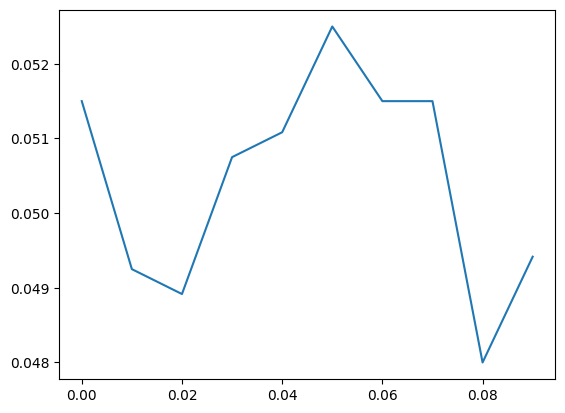

In [93]:
x = [i/100 for i in range(10)]

plt.plot(x, ber_ber)